## Wide&Deep模型的多输出

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.19.5
pandas 1.3.0
sklearn 0.24.2
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# 多输出
intput_wide = keras.layers.Input(shape=[5])
intput_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30,activation='relu')(intput_deep)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.concatenate([intput_wide,hidden2])
output1 = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[intput_wide, intput_deep],
                           outputs=[output1,output2])

model.summary()
model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

2021-07-26 18:02:08.879130: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]
history = model.fit([x_train_scaled_wide, x_train_scaled_deep], 
                    [y_train,y_train],
                    validation_data = ([x_valid_scaled_wide,
                                       x_valid_scaled_deep], 
                                       [y_valid,y_valid]),
                    epochs = 10,
                    callbacks = callbacks)

2021-07-26 18:02:09.144327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
363/363 [==============================] - 3s 5ms/step - loss: 3.4570 - dense_2_loss: 1.5804 - dense_3_loss: 1.8767 - val_loss: 1.6867 - val_dense_2_loss: 0.7122 - val_dense_3_loss: 0.9745
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 1.2824 - dense_2_loss: 0.5622 - dense_3_loss: 0.7202 - val_loss: 1.0967 - val_dense_2_loss: 0.4740 - val_dense_3_loss: 0.6228
Epoch 3/10
363/363 [==============================] - 2s 4ms/step - loss: 1.0158 - dense_2_loss: 0.4388 - dense_3_loss: 0.5770 - val_loss: 1.0171 - val_dense_2_loss: 0.4349 - val_dense_3_loss: 0.5822
Epoch 4/10
363/363 [==============================] - 2s 4ms/step - loss: 0.9443 - dense_2_loss: 0.4091 - dense_3_loss: 0.5352 - val_loss: 0.9588 - val_dense_2_loss: 0.4190 - val_dense_3_loss: 0.5398
Epoch 5/10
363/363 [==============================] - 2s 5ms/step - loss: 0.9017 - dense_2_loss: 0.3946 - dense_3_loss: 0.5071 - val_loss: 0.9178 - val_dense_2_loss: 0.4106 - val_dense_3_loss: 0.5072


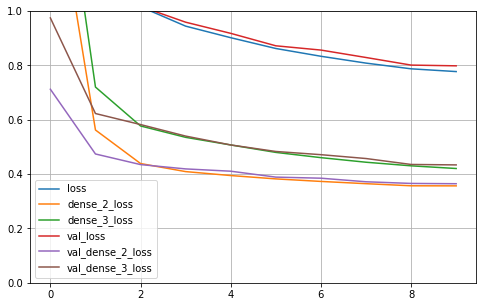

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [8]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep], y_test)

162/162 [==============================] - 1s 4ms/step - loss: 0.8122 - dense_2_loss: 0.3721 - dense_3_loss: 0.4402A: 0s - loss: 0.8250 - dense_2_loss: 0.3730 - dense_3_loss:


[0.812246561050415, 0.37209552526474, 0.4401509165763855]

In [9]:
h = history.history

In [13]:
h.keys()
pd.DataFrame(h)

,loss,dense_2_loss,dense_3_loss,val_loss,val_dense_2_loss,val_dense_3_loss
0,3.457015,1.580363,1.876652,1.686673,0.712188,0.974485
1,1.282411,0.562214,0.720196,1.096743,0.473960,0.622783
2,1.015788,0.438764,0.577025,1.017148,0.434934,0.582213
3,0.944294,0.409115,0.535178,0.958809,0.419030,0.539779
4,0.901745,0.394616,0.507130,0.917769,0.410594,0.507176
5,0.862036,0.382275,0.479761,0.871958,0.388818,0.483141
6,0.833449,0.372975,0.460474,0.856246,0.384845,0.471400
7,0.808286,0.364687,0.443598,0.828924,0.371695,0.457229
8,0.787280,0.356919,0.430361,0.800977,0.365587,0.435390
9,0.777132,0.356619,0.420512,0.798296,0.364524,0.433772
